In [97]:
FOLDER = "./data/infracoes"
PREFIX = "infracoes_"
SUFFIX = ""
EXTENSION = "csv"

FILES = []
for y in range (2019, 2025):
    for m in range (1, 13):
        FILES.append(
            {
                "year": y,
                "month": m,
                "path": f'{FOLDER}/{PREFIX}{y}_{m:02d}{SUFFIX}.{EXTENSION}'
            }
        )

FILES

[{'year': 2019, 'month': 1, 'path': './data/infracoes/infracoes_2019_01.csv'},
 {'year': 2019, 'month': 2, 'path': './data/infracoes/infracoes_2019_02.csv'},
 {'year': 2019, 'month': 3, 'path': './data/infracoes/infracoes_2019_03.csv'},
 {'year': 2019, 'month': 4, 'path': './data/infracoes/infracoes_2019_04.csv'},
 {'year': 2019, 'month': 5, 'path': './data/infracoes/infracoes_2019_05.csv'},
 {'year': 2019, 'month': 6, 'path': './data/infracoes/infracoes_2019_06.csv'},
 {'year': 2019, 'month': 7, 'path': './data/infracoes/infracoes_2019_07.csv'},
 {'year': 2019, 'month': 8, 'path': './data/infracoes/infracoes_2019_08.csv'},
 {'year': 2019, 'month': 9, 'path': './data/infracoes/infracoes_2019_09.csv'},
 {'year': 2019, 'month': 10, 'path': './data/infracoes/infracoes_2019_10.csv'},
 {'year': 2019, 'month': 11, 'path': './data/infracoes/infracoes_2019_11.csv'},
 {'year': 2019, 'month': 12, 'path': './data/infracoes/infracoes_2019_12.csv'},
 {'year': 2020, 'month': 1, 'path': './data/infra

In [146]:
import pandas as pd
from unidecode import unidecode

ENCODINGS = ['utf-8', 'utf-16']
SEPARATORS = [',', ';']
VARIATIONS = ['Codigo da Infracao', 'Codigo_Infracao', 'Cod _Infração', 'COD_INFRACAO']
CORRECT = "INFRACAO"

all_data = []

for file in FILES:
    for encoding in ENCODINGS:
        for separator in SEPARATORS:
            try:
                data = pd.read_csv(file["path"], sep=separator, encoding=encoding)
                
                if len(data.columns) == 1: # Wrong separator
                    continue

                if len(data.columns) > 3: # Each state in a column
                    data = data.drop(0)
                    data.rename(columns={data.columns[0]: CORRECT})
                    data.columns = [CORRECT] + list(data.columns[1:])
                    data = data.melt(id_vars=[CORRECT], var_name="UF", value_name="Quantidade")

                # Normalize columns
                data.columns = [unidecode(col).upper() for col in data.columns]
                for variation in VARIATIONS:
                    adjusted_variation = unidecode(variation).upper()
                    if adjusted_variation in data.columns:
                        data = data.rename(columns={adjusted_variation: CORRECT})
                        break
                data = data[['UF', CORRECT, 'QUANTIDADE']]

                # Adjust numbers
                data['QUANTIDADE'] = data['QUANTIDADE'].fillna(0)
                data['QUANTIDADE'] = data['QUANTIDADE'].astype(str).str.replace('.', '', regex=False).astype(int)

                # Add time identifiers
                data['MES'] = file['month']
                data['ANO'] = file['year']                    
                all_data.append(data)

                break
            except UnicodeError: # Wrong encoding
                continue

df = pd.concat(all_data)
df.head()
    

,UF,INFRACAO,QUANTIDADE,MES,ANO
0,ACRE,5002,15,1,2019
1,ACRE,5010,827,1,2019
2,ACRE,5029,12,1,2019
3,ACRE,5037,48,1,2019
4,ACRE,5045,514,1,2019


In [173]:
import pandas as pd

CODES_FILE = "codigos.xlsx"

code_to_name = pd.read_excel(f'{FOLDER}/{CODES_FILE}')

code_to_name = code_to_name[['Código da Infração', 'Descrição da Infração']]
code_to_name.columns = ['INFRACAO', 'DESCRICAO']
# data = data.merge(code_to_name, on='INFRACAO', how='left')

code_name_mapping = dict(zip(code_to_name['INFRACAO'].astype(int), code_to_name['DESCRICAO']))
code_name_mapping

{5002: 'Multa, por não identificação do condutor infrator, imposta à pessoa jurídica ',
 5010: 'Dirigir veículo sem possuir CNH ou Permissão para Dirigir',
 5029: 'Dirigir veículo com CNH ou PPD com suspensão do direito de dirigir',
 5037: 'Dirigir veículo com CNH de categoria diferente da do veículo e Dirigir veículo com CNH ou PPD com suspensão do direito de dirigir',
 5045: 'Dirigir veículo com validade de CNH/PPD vencida há mais de 30 dias',
 5053: 'Dirigir veículo sem usar lentes corretoras de visão e Dirigir veículo sem usar aparelho auxiliar de audição e Dirigir veículo sem usar aparelho auxiliar de prótese física e Dirigir veículo s/ adaptações impostas na concessão/renovação licença conduzir',
 5061: 'Entregar veículo a pessoa sem CNH ou Permissão para Dirigir',
 5070: 'Entregar veículo a pessoa com CNH ou PPD cassada e Entregar veículo a pessoa com CNH ou PPD com suspensão do direito de dirigir',
 5088: 'Entregar veículo a pessoa com CNH de categoria diferente da do veículo e

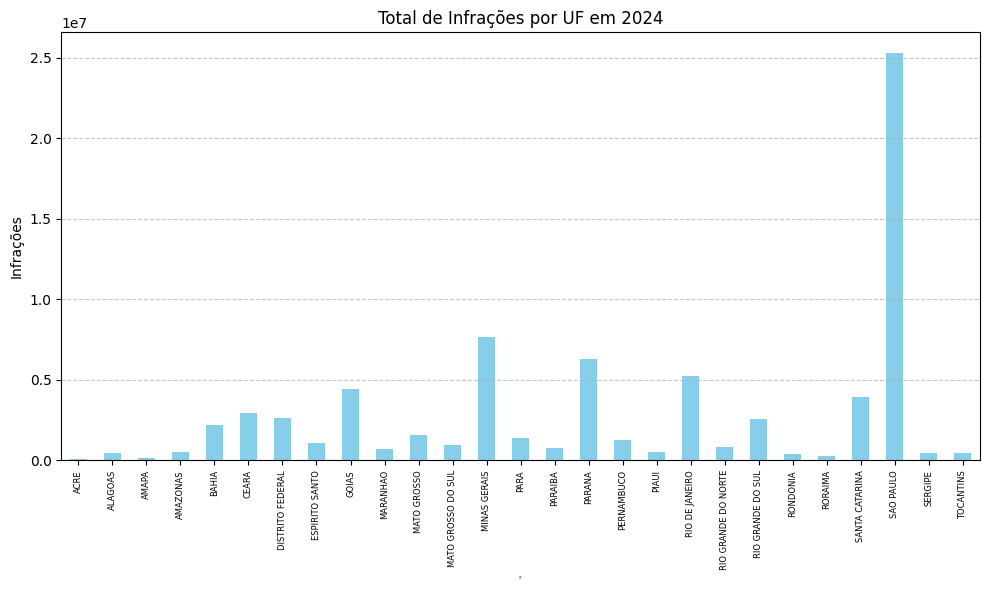

/tmp/ipykernel_27804/288449760.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


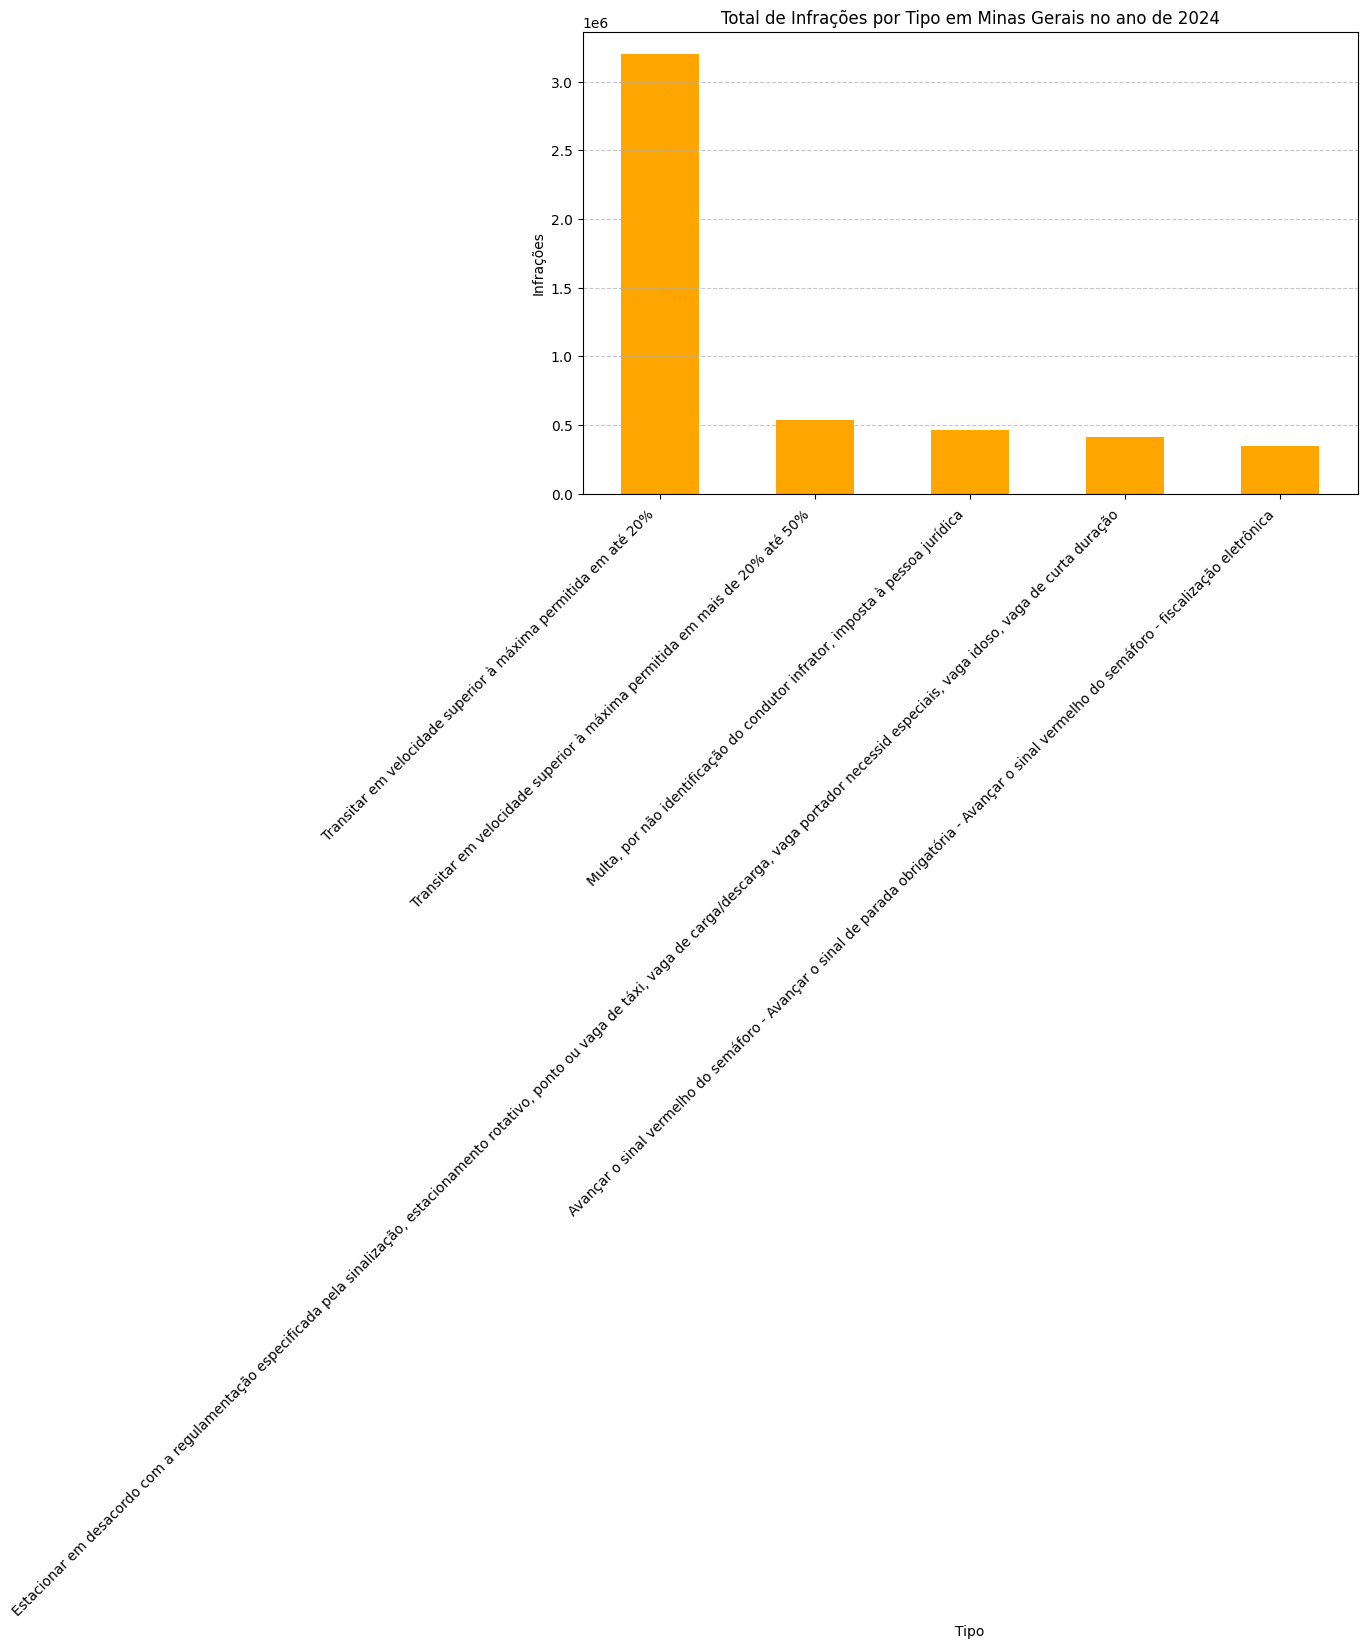

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total infractions by state
total_by_state = df[(df['ANO'] == 2024)].groupby('UF')['QUANTIDADE'].sum()

plt.figure(figsize=(10, 6))
total_by_state.plot(kind='bar', color='skyblue')
plt.title('Total de Infrações por UF em 2024')
plt.xlabel('UF', fontsize=2)
plt.ylabel('Infrações')
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Total infractions by type
total_by_infraction = df[(df['ANO'] == 2024) & (df['UF'] == "MINAS GERAIS")].groupby('INFRACAO')['QUANTIDADE'].sum()
top_5_infractions = total_by_infraction.sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 6))
ax = top_5_infractions.plot(kind='bar', color='orange')
ax.set_xticklabels([code_name_mapping.get(int(code), f"Code {code}") for code in top_5_infractions.index], 
                   rotation=45, fontsize=10, ha='right')
plt.title('Total de Infrações por Tipo em Minas Gerais no ano de 2024')
plt.xlabel('Tipo')
plt.ylabel('Infrações')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

